In [5]:
# Fix for importing utils
import sys, os
import utils
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, Image
import dataframe_image as dfi

np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
font = {'family' : 'Ubuntu',
        'size'   : 22}

matplotlib.rc('font', **font)

# Visualization of ZPOS Data

Expects folder tree structure of

```
./
|- 02_Pozyx_Positioning_Data
|   |-KITCHEN
|   |-ZPOS
|
|- 03_Labels
    |-KITCHEN
    |-ZPOS
```
- Sitting was at around 10cm off of the ground. Standing was at around 1.6m


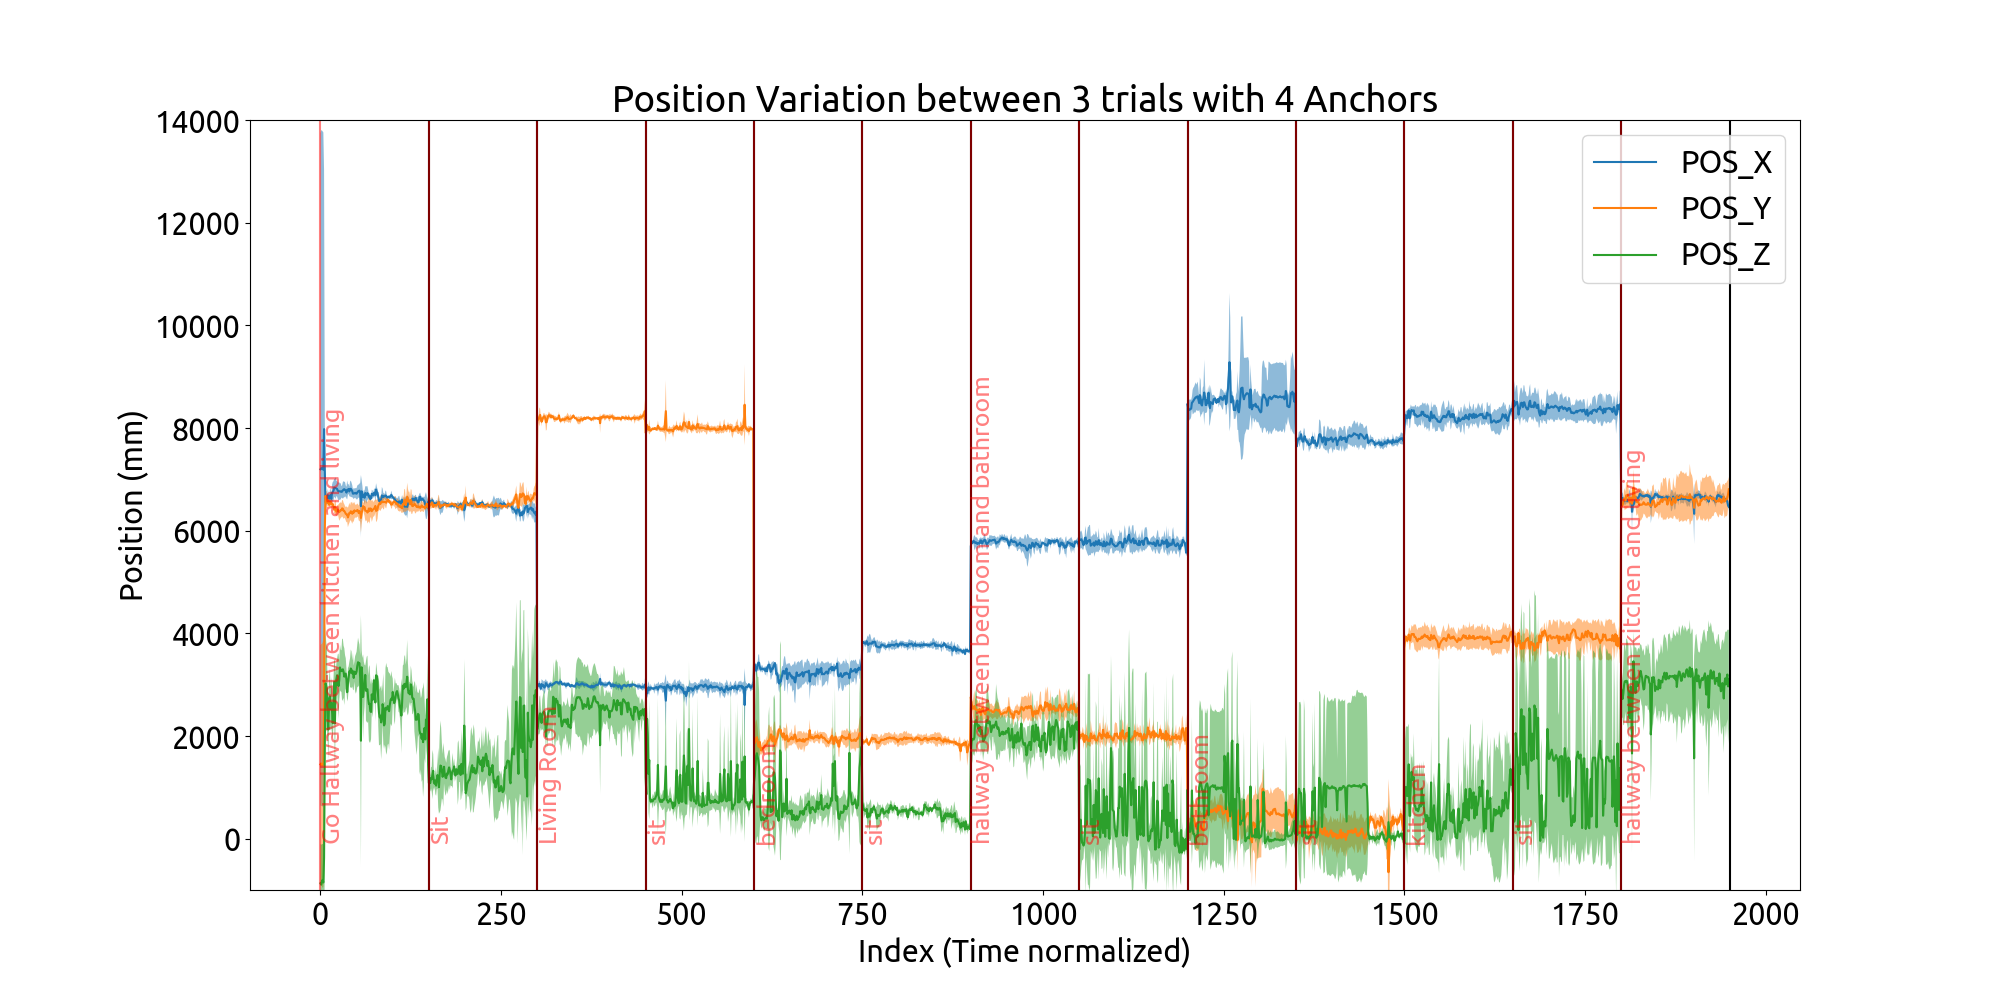

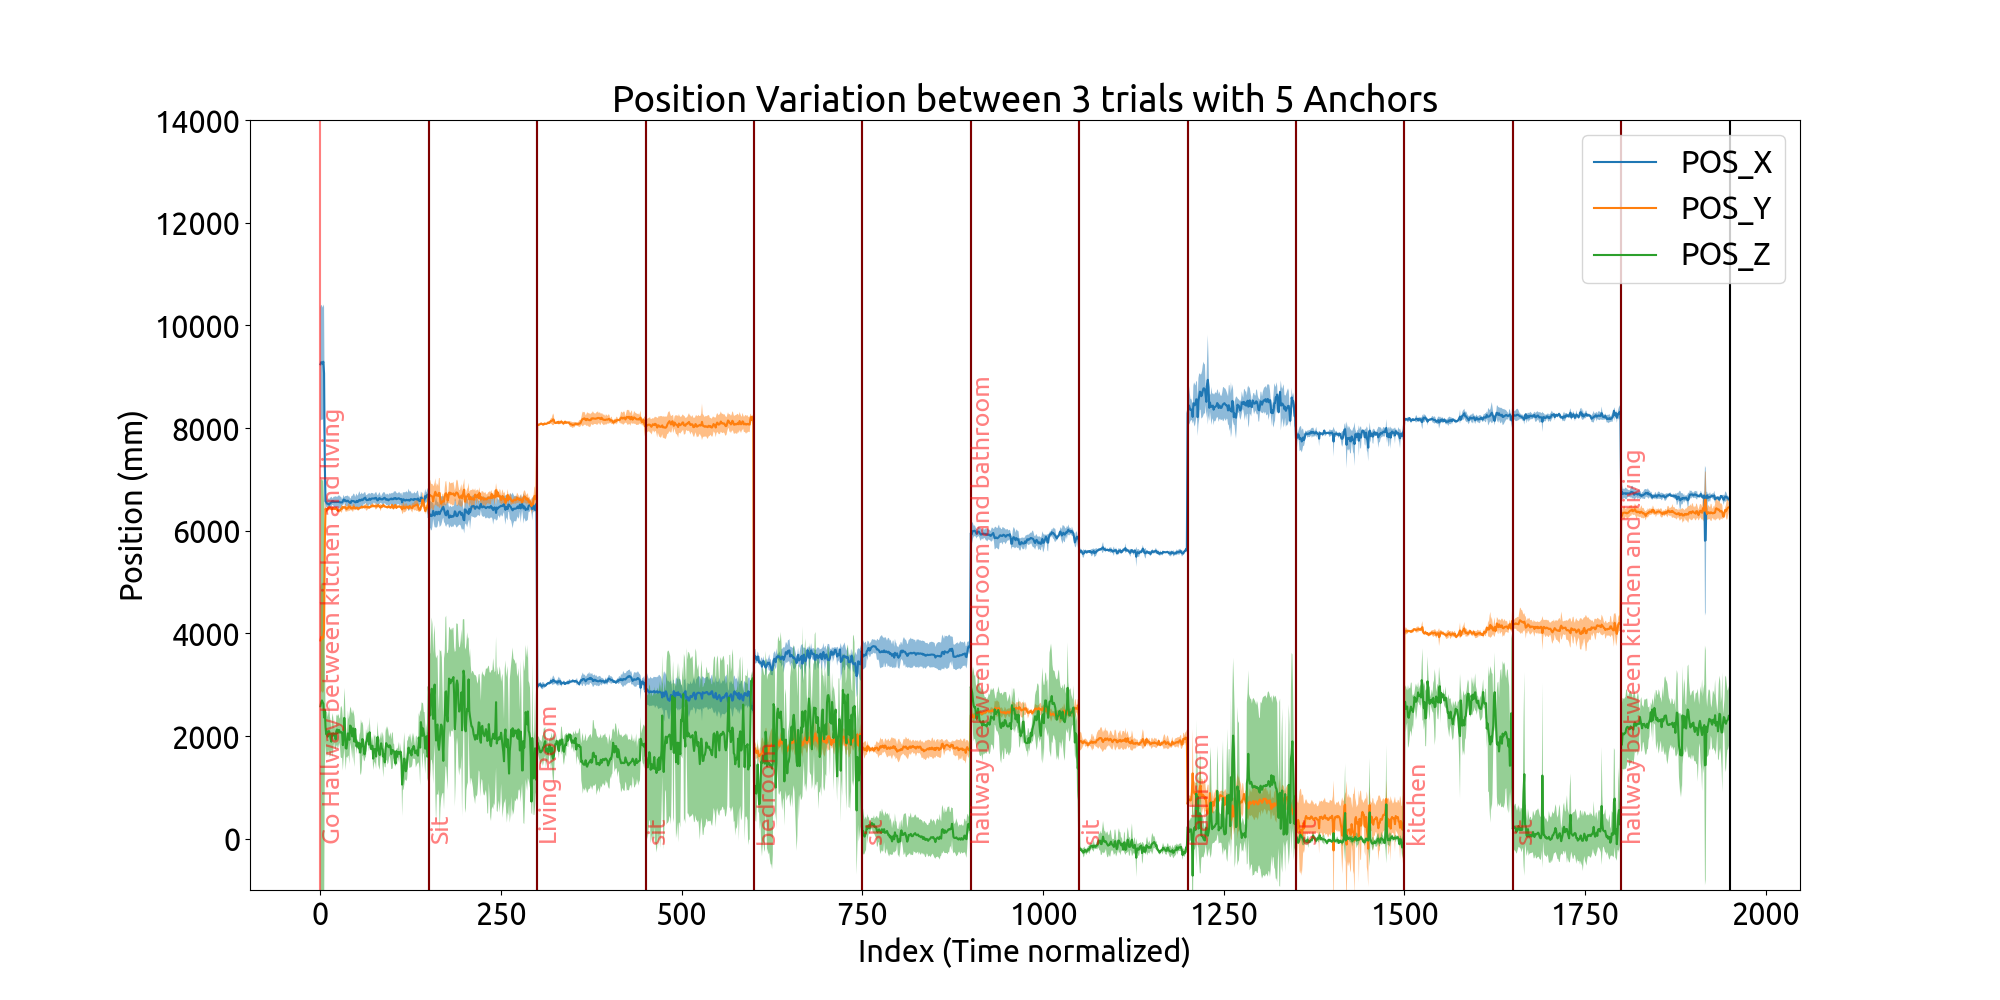

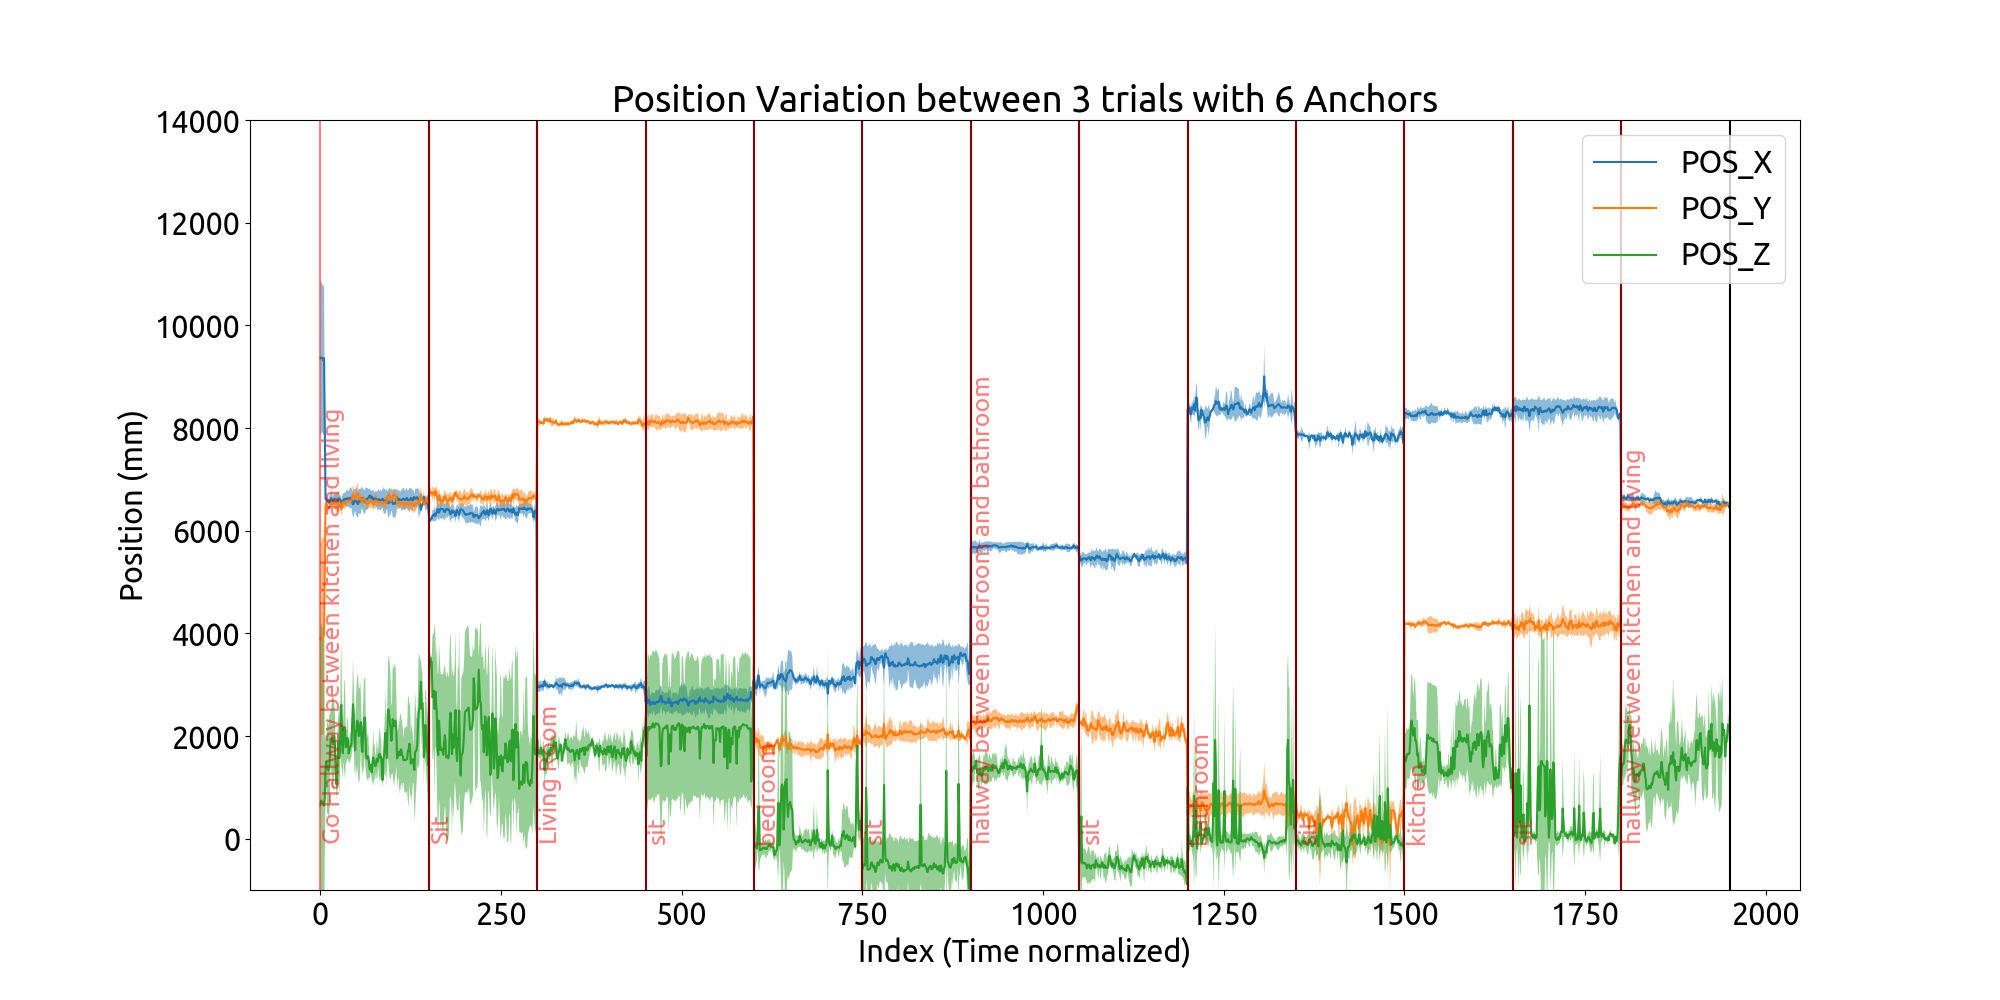

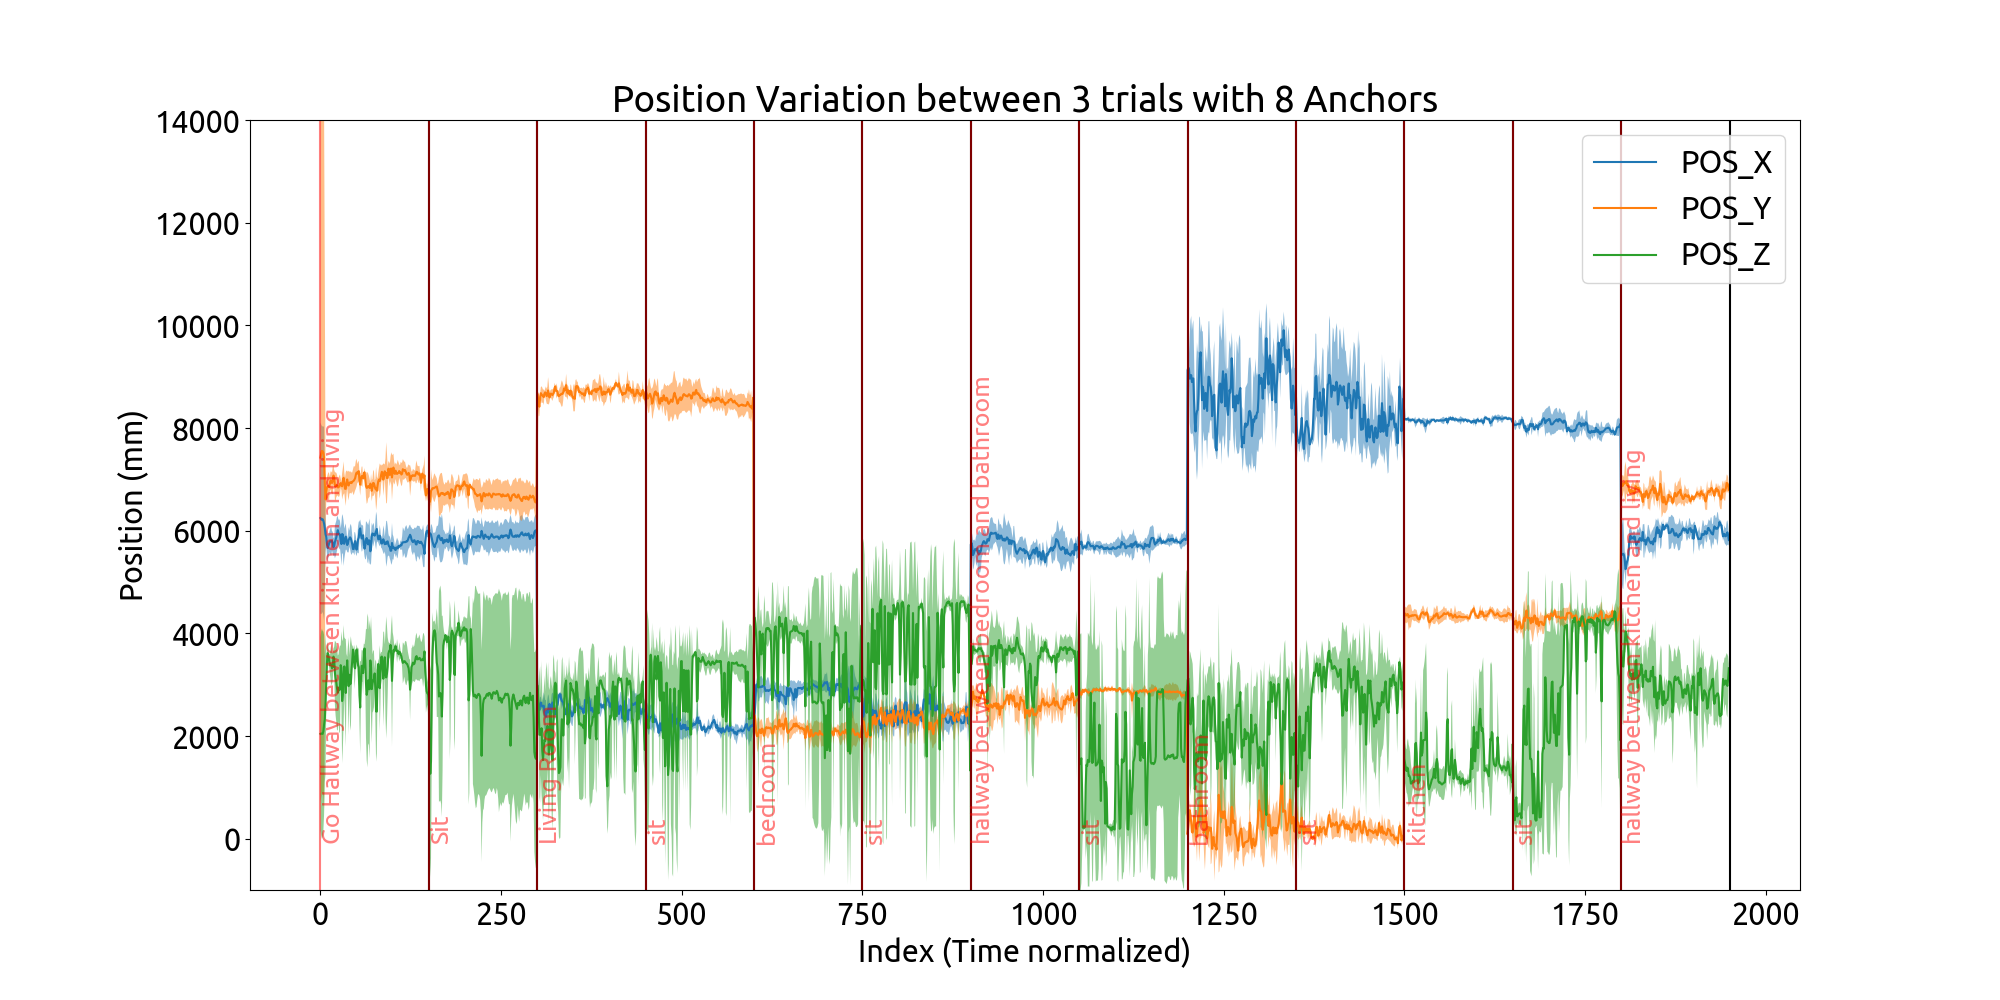

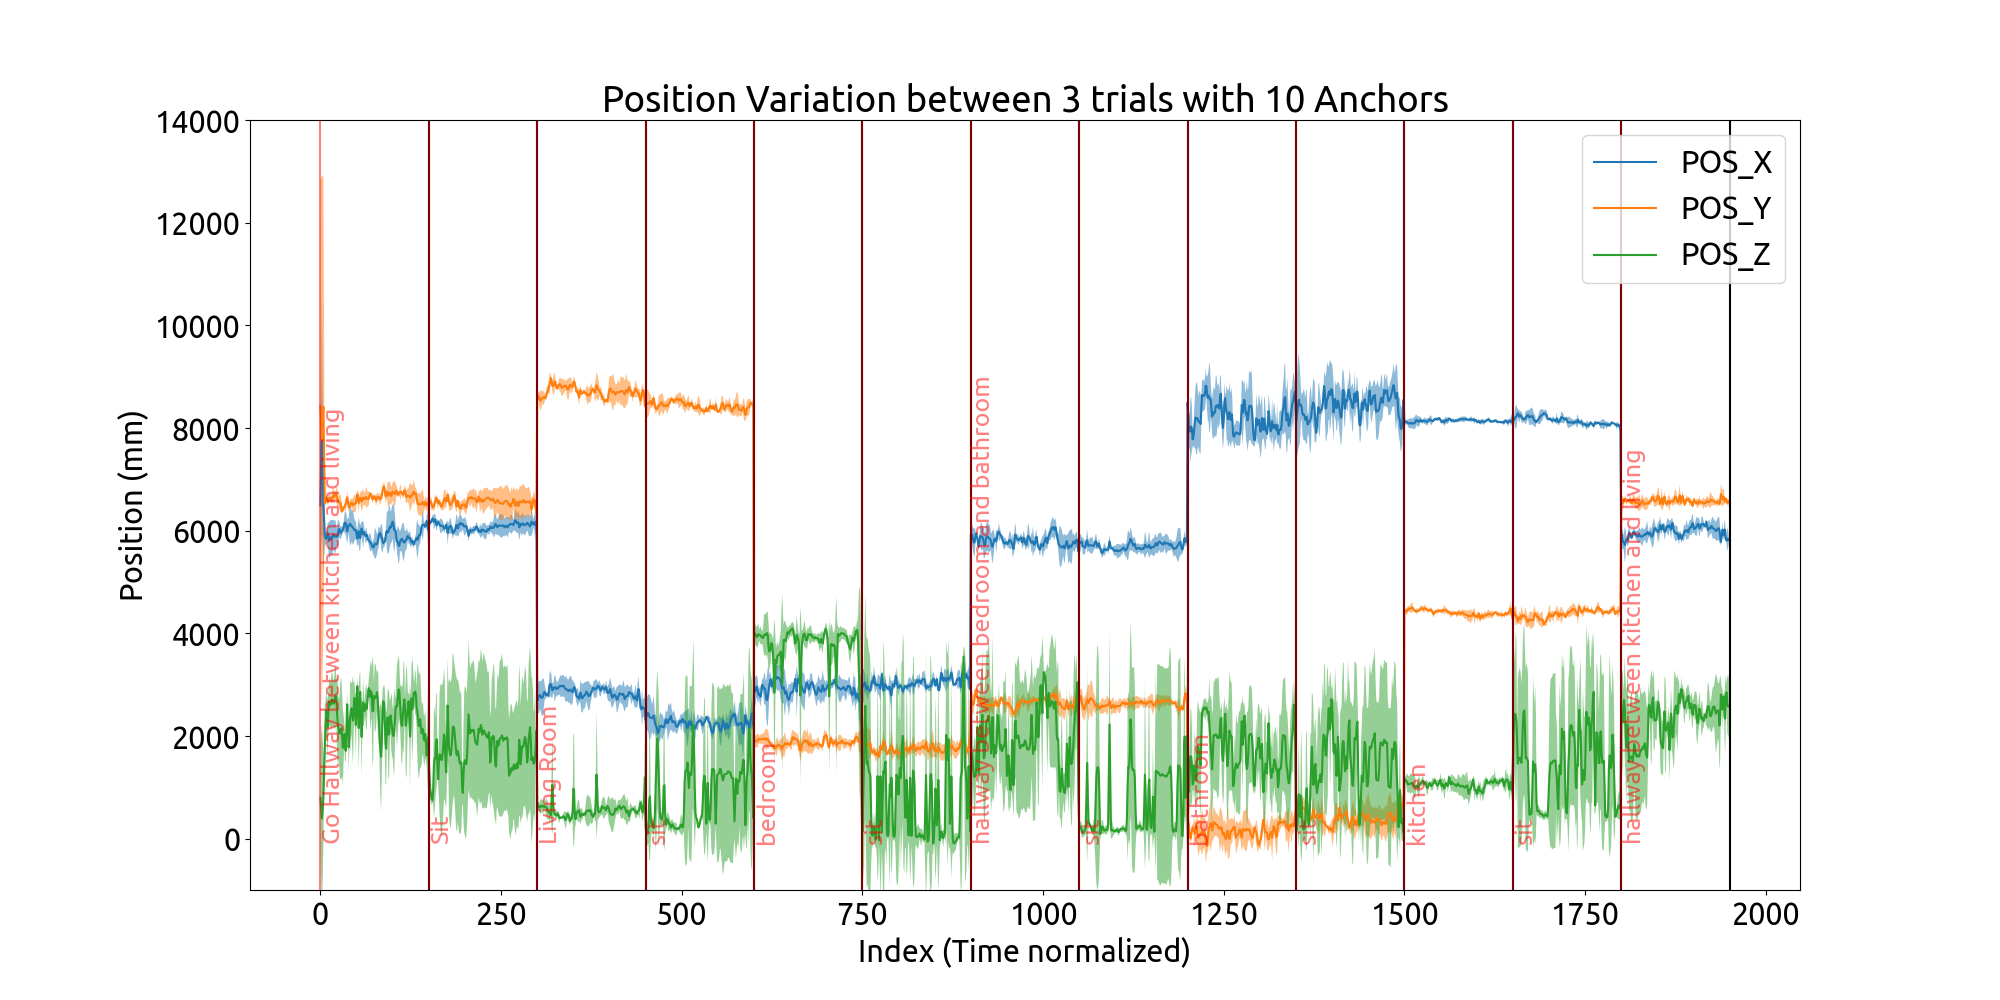

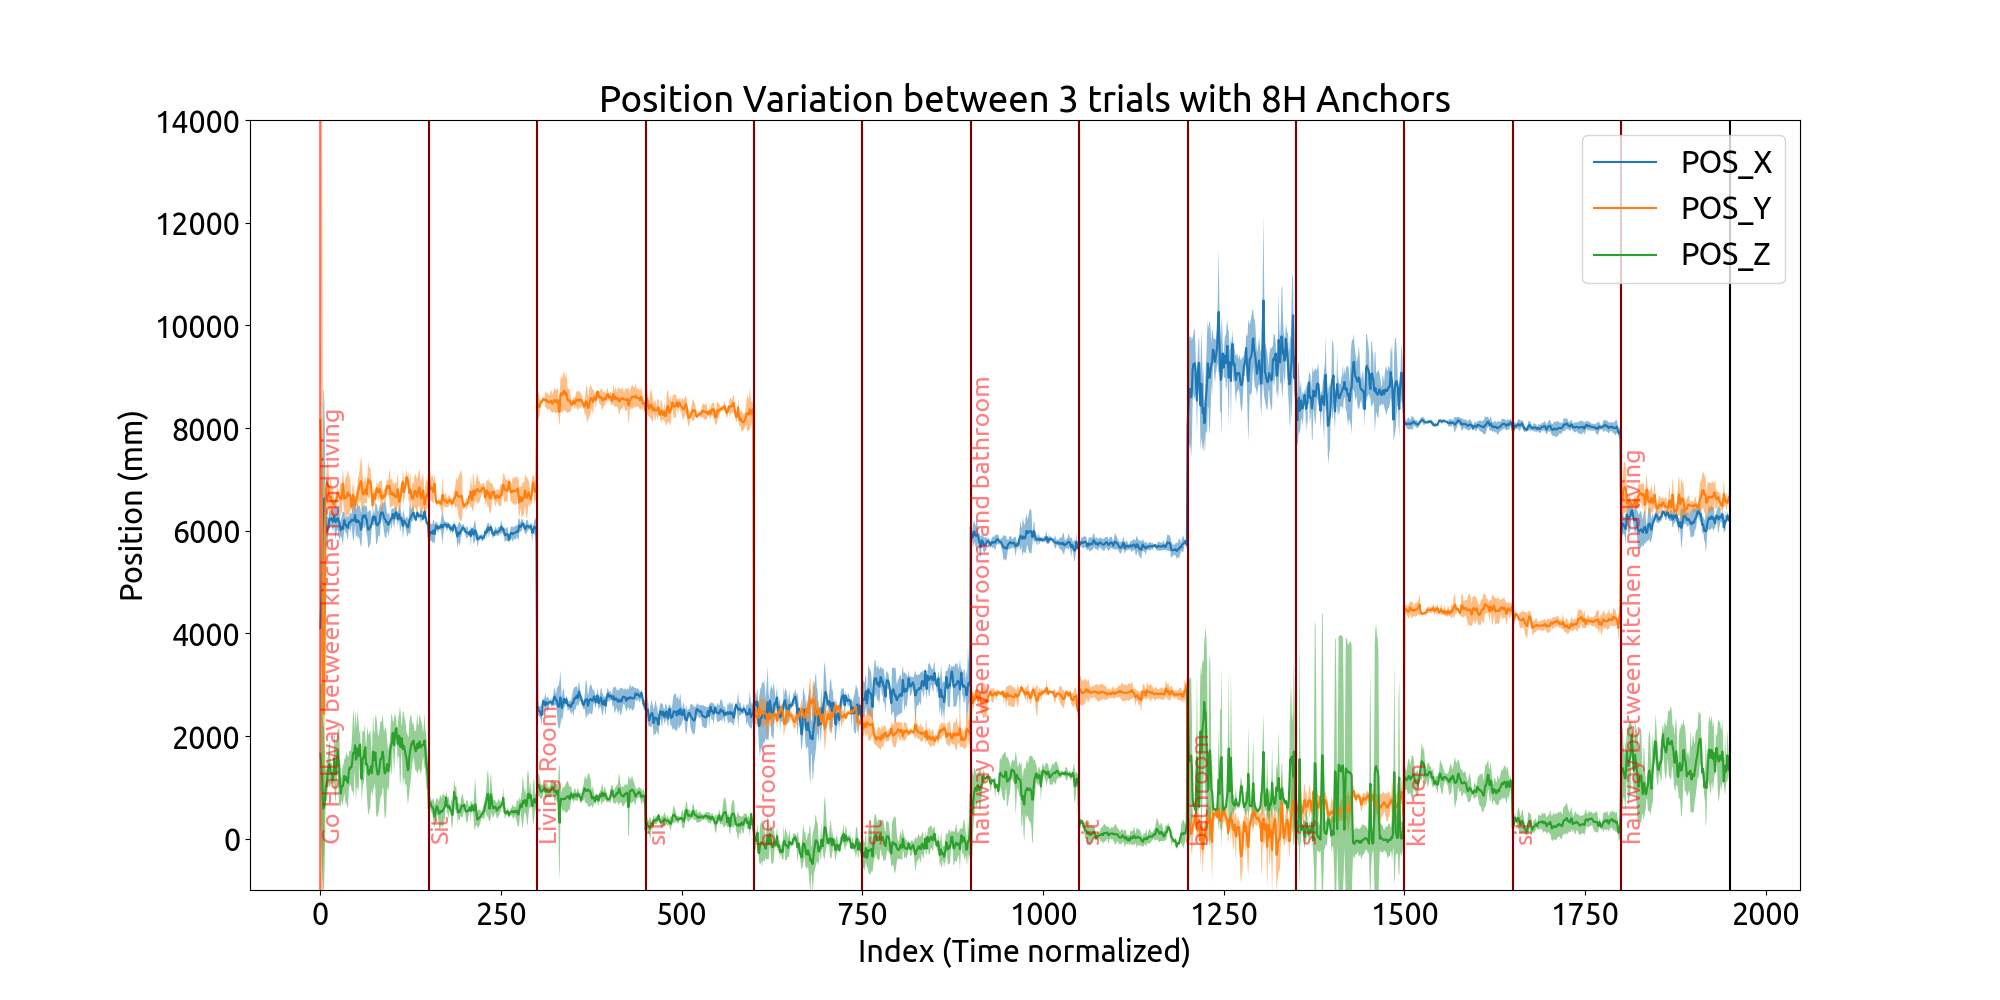

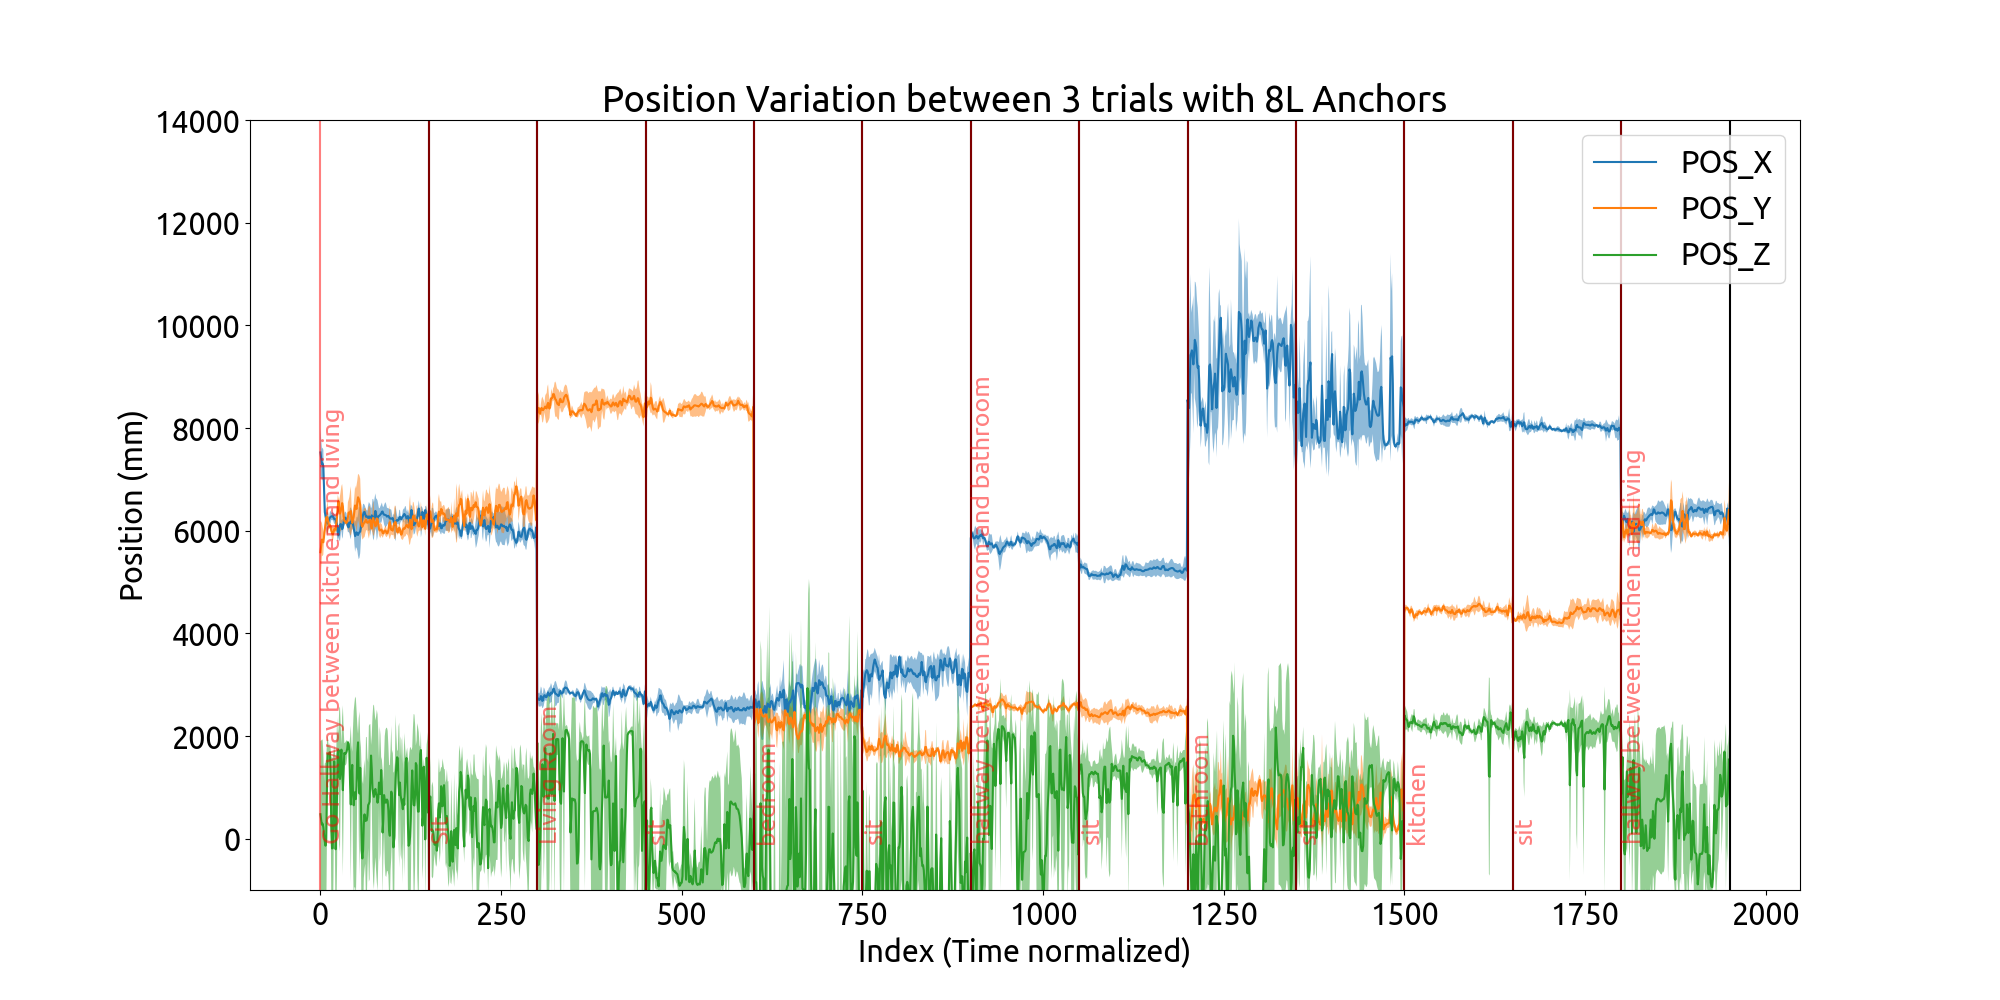

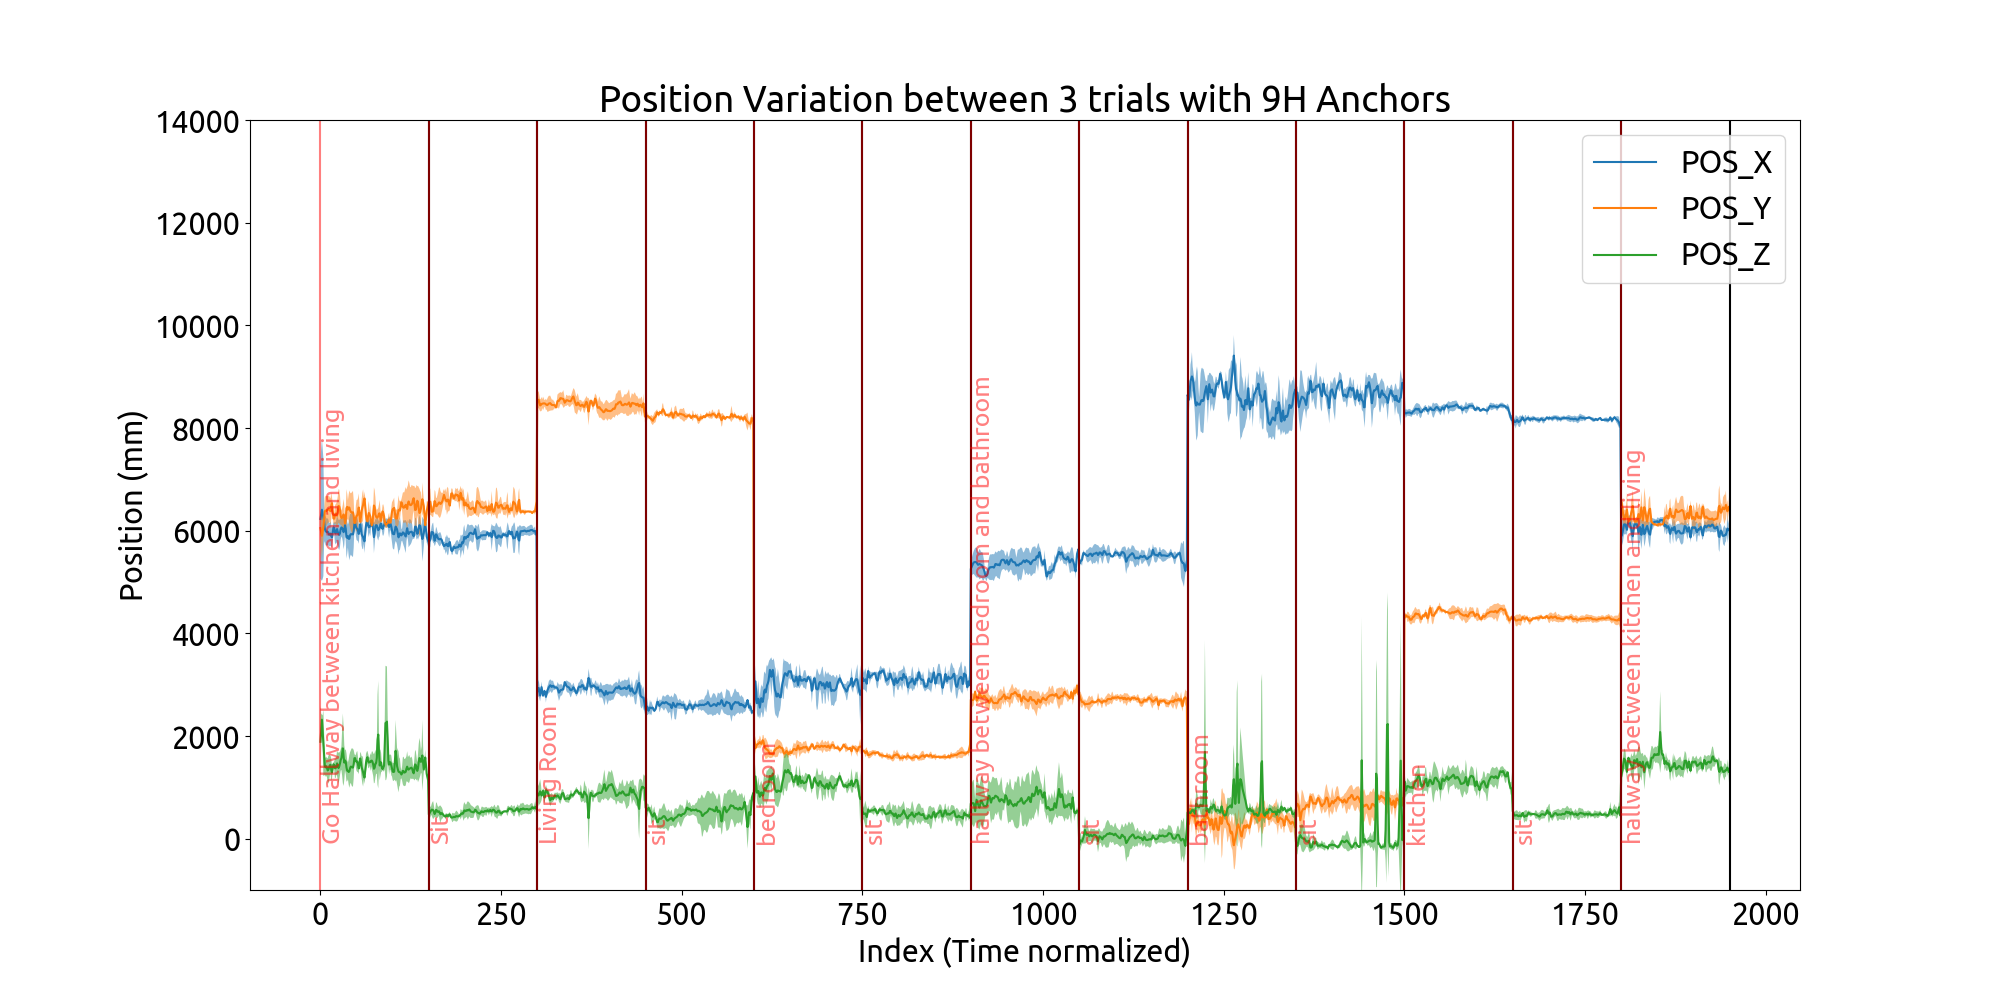

No such comm: bcae8c77f65147e2989d446407d61297
No such comm: d186b6815c414936b0bf2c008640f7de
No such comm: cf96a2d17c2f48fca9a0e87438ad3bc6
No such comm: bf6ffd2b249d40839ab595c47ce3a91c
No such comm: 4c6468d018bb46c3a716ac5fe262ff76
No such comm: ee0a37d6770048a88bc6e0dcfd5023f7
No such comm: 2fe0eb911b6d4ee0b2dd65d1c2f9fe66
No such comm: 7f3ba6e5c9ce40b686e7ac5c4d0c08bb


In [6]:
labels_dir = "03_Labels"
data_dir = "02_Pozyx_Positioning_Data"
NUM_NORM_POINTS = 150
TRIAL_NUM = 3
ANCHOR_CONFIG = ["4", "5", "6", "8", "10", "8H", "8L", "9H"]
HEIGHTS = {
    "4": {"stand": 1294, "sit": 97},
	"5": {"stand": 1294, "sit": 97},
	"6": {"stand": 1294, "sit": 97},
	"8": {"stand": 1440, "sit": 685},
	"10": {"stand": 1440, "sit": 685},
	"8H": {"stand": 1440, "sit": 685},
	"8L": {"stand": 1440, "sit": 685},
	"9H": {"stand": 1440, "sit": 685}
}

POSITIONS = {
    'Go Hallway between kitchen and living':        {'x': 6291, 'y': 6064},
	'Go Hallway between kitchen and living(sit)':   {'x': 6291, 'y': 6064},
	'Living Room':                                  {'x': 2489, 'y': 8077},
	'Living Room(sit)':                             {'x': 2489, 'y': 8077},
	'bathroom':                                     {'x': 8061, 'y': 718},
	'bathroom(sit)':                                {'x': 8061, 'y': 718},
	'bedroom':                                      {'x': 3487, 'y': 1710},
	'bedroom(sit)':                                 {'x': 3487, 'y': 1710},
	'hallway between bedroom and bathroom':         {'x': 5732, 'y': 2557},
	'hallway between bedroom and bathroom(sit)':    {'x': 5732, 'y': 2557},
	'hallway between kitchen and living':           {'x': 6291, 'y': 6064},
	'kitchen':                                      {'x': 8453, 'y': 4066},
	'kitchen(sit)':                                 {'x': 8453, 'y': 4066}
}


%matplotlib widget
for anchor in ANCHOR_CONFIG:
    processed_trials = pd.DataFrame()
    for trial in range(TRIAL_NUM):
        TYPE = "ZPOS"
        ANCHORS = anchor
        TRIAL = trial+1

        label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
        data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

        label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
        data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

        labels = utils.extract_time_labels(label_fp)

        data = pd.read_csv(data_fp)
        if (len(data.columns) == 14):
            data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y','GYRO_Z', 'TagId']
        else:
            data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z']
        data = data.set_index('Timestamp')

        # Segment the data into only the standing still portions.
        moving_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[1::2], labels[2::2])]
        moving_periods.append([float(labels[-1]['Timestamp']), float(labels[-1]['Timestamp'])+120])
        standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

        ##################### CLEANING THE DATA ########################## 
        cleaned_data = (data
                        .iloc[:, :-1]
                        .pipe(utils.remove_periods, moving_periods)
                        .pipe(utils.interp1d_periods, standing_periods, num_points=NUM_NORM_POINTS)
                        .reset_index(drop=True)
                    )
        ##################################################################


        # To normalize in time, drop the index and fix the indexing (make start overlap with 10sec end so red vertical line overlays black 10 sec elapsed line)
        index = 0
        drop_index_labels = []
        for ind, _ in enumerate(labels[0::2]):
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2]['Label']})
            index += NUM_NORM_POINTS
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2+1]['Label']})


        # utils.plot_pozyx_data_with_timings(cleaned_data, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)
        # utils.plot_pozyx_data_with_timings(cleaned_data, ['Heading'], drop_index_labels, ylim=(0,360))
        processed_trials = pd.concat([processed_trials, cleaned_data], axis=0)

    # Means and Standard deviations for ensemble averages
    means = processed_trials.groupby(processed_trials.index).mean()
    stds = processed_trials.groupby(processed_trials.index).std()

    # Position
    ax = utils.plot_pozyx_data_with_timings(means, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels, ylim=(-1000, 14000))
    ax.fill_between(means.index, means['POS_X'] + stds['POS_X'], means['POS_X'] - stds['POS_X'], alpha=0.5)
    ax.fill_between(means.index, means['POS_Y'] + stds['POS_Y'], means['POS_Y'] - stds['POS_Y'], alpha=0.5)
    ax.fill_between(means.index, means['POS_Z'] + stds['POS_Z'], means['POS_Z'] - stds['POS_Z'], alpha=0.5)
    ax.set_title(f"Position Variation between {TRIAL_NUM} trials with {ANCHORS} Anchors")
    ax.set_xlabel("Index (Time normalized)")
    # ax.axhline(HEIGHTS[anchor]["stand"], color="black")
    # ax.text(-100, HEIGHTS[anchor]["stand"]+10, "Stand")
    # ax.axhline(HEIGHTS[anchor]["sit"], color="black")
    # ax.text(-100, HEIGHTS[anchor]["sit"]+10, "Squat")

    # # Heading
    # ax = utils.plot_pozyx_data_with_timings(means, ['Heading'], drop_index_labels, ylim=(0, 360), ylabel="Heading (Deg)")
    # ax.fill_between(means.index, means['Heading'] + stds['Heading'], means['Heading'] - stds['Heading'], alpha=0.5)
    # ax.set_title(f"Heading Variation between {TRIAL_NUM} trials with {ANCHORS} Anchors")

In [16]:


pd.set_option('display.float_format', lambda x: '%.5f' % x)
labels_dir = "03_Labels"
data_dir = "02_Pozyx_Positioning_Data"
NUM_NORM_POINTS = 150
TRIAL_NUM = 3
ANCHOR_CONFIG = ["4", "5", "6", "8", "10", "8H", "8L", "9H"]
HEIGHTS = {
    "4": {"stand": 1294, "sit": 97},
	"5": {"stand": 1294, "sit": 97},
	"6": {"stand": 1294, "sit": 97},
	"8": {"stand": 1440, "sit": 685},
	"10": {"stand": 1440, "sit": 685},
	"8H": {"stand": 1440, "sit": 685},
	"8L": {"stand": 1440, "sit": 685},
	"9H": {"stand": 1440, "sit": 685}
}

x_all_stds = pd.DataFrame()
x_all_means = pd.DataFrame()
y_all_stds = pd.DataFrame()
y_all_means = pd.DataFrame()
z_all_stds = pd.DataFrame()
z_all_means = pd.DataFrame()

%matplotlib inline
for anchor in ANCHOR_CONFIG:
    processed_trials = pd.DataFrame()
    for trial in range(TRIAL_NUM):
        TYPE = "ZPOS"
        ANCHORS = anchor
        TRIAL = trial+1

        label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
        data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

        label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
        data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

        labels = utils.extract_time_labels(label_fp)

        data = pd.read_csv(data_fp)
        if (len(data.columns) == 14):
            data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y','GYRO_Z', 'TagId']
        else:
            data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z']
        data = data.set_index('Timestamp')

        # Segment the data into only the standing still portions.
        moving_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[1::2], labels[2::2])]
        moving_periods.append([float(labels[-1]['Timestamp']), float(labels[-1]['Timestamp'])+120])
        standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

        ##################### CLEANING THE DATA ########################## 
        cleaned_data = (data
                        .iloc[:, :-1]
                        .pipe(utils.remove_periods, moving_periods)
                        .pipe(utils.interp1d_periods, standing_periods, num_points=NUM_NORM_POINTS)
                        .reset_index(drop=True)
                    )
        ##################################################################

        # To normalize in time, drop the index and fix the indexing (make start overlap with 10sec end)
        index = 0
        drop_index_labels = []
        for ind, _ in enumerate(labels[0::2]):
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2]['Label']})
            index += NUM_NORM_POINTS
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2+1]['Label']})

        # Add the locations to each standing/sitting portion
        index = 0
        filtered_labels = list(sorted(list(filter(lambda x: x['Label'] != '10 sec elapsed', drop_index_labels)), key=lambda x: float(x['Timestamp'])))
        for ind, _ in enumerate(filtered_labels[0::2]):
            cleaned_data.loc[index:index+NUM_NORM_POINTS, 'Location'] = filtered_labels[ind*2]['Label']
            if ind*2 + 1 < len(filtered_labels):
                cleaned_data.loc[index+NUM_NORM_POINTS:index+2*NUM_NORM_POINTS, 'Location'] = filtered_labels[ind*2]['Label'] + "(sit)"
            index += 2*NUM_NORM_POINTS

        processed_trials = pd.concat([processed_trials, cleaned_data], axis=0)
        pd.set_option('display.max_rows', processed_trials.shape[0]+1)



    # Means and Standard deviations for ensemble averages
    z_means = processed_trials.groupby(processed_trials.Location).mean().loc[:, "POS_Z"]
    z_stds = processed_trials.groupby(processed_trials.Location).std().loc[:, "POS_Z"]
    z_stds.name = z_stds.name + f"_A{anchor}"
    z_means.name = z_means.name + f"_A{anchor}"
    z_all_stds = pd.concat([z_all_stds, z_stds], axis=1)
    z_all_means = pd.concat([z_all_means, z_means], axis=1)

    x_means = processed_trials.groupby(processed_trials.Location).mean().loc[:, "POS_X"]
    x_stds = processed_trials.groupby(processed_trials.Location).std().loc[:, "POS_X"]
    x_stds.name = x_stds.name + f"_A{anchor}"
    x_means.name = x_means.name + f"_A{anchor}"
    x_all_stds = pd.concat([x_all_stds, x_stds], axis=1)
    x_all_means = pd.concat([x_all_means, x_means], axis=1)

    y_means = processed_trials.groupby(processed_trials.Location).mean().loc[:, "POS_Y"]
    y_stds = processed_trials.groupby(processed_trials.Location).std().loc[:, "POS_Y"]
    y_stds.name = y_stds.name + f"_A{anchor}"
    y_means.name = y_means.name + f"_A{anchor}"
    y_all_stds = pd.concat([y_all_stds, y_stds], axis=1)
    y_all_means = pd.concat([y_all_means, y_means], axis=1)
    # stats = pd.concat([means, stds], axis=1)
    # stats.columns = ["POS_Z Mean", "POS_Z Std"]


    # display(stats.style.background_gradient(axis=0))
    # means = means.loc[:, "POS_Z"].style.background_gradient(axis=0)  
    # stds = stds.loc[:, "POS_Z"].style.background_gradient(axis=0)  

    # print("*"*20 + f"A{anchor}" + "*"*20)
    # print("MEANS")
    # display(means)
    # print("STD")
    # display(stds)
display(z_all_means)
display(x_all_means)
display(y_all_means)

POS_Z_A4   POS_Z_A5   POS_Z_A6  \
Go Hallway between kitchen and living      2616.77425 1862.82011 1772.73821   
Go Hallway between kitchen and living(sit) 1466.75325 2174.84695 1936.57905   
Living Room                                2509.05652 1661.15669 1710.89180   
Living Room(sit)                            887.77519 1868.43513 2067.93128   
bathroom                                    454.04114  627.37849  147.23523   
bathroom(sit)                               529.05380   -4.93527  -14.68349   
bedroom                                     718.63860 1951.61668   78.24413   
bedroom(sit)                                493.98831   84.14041 -450.50130   
hallway between bedroom and bathroom       2034.00887 2327.99430 1335.18955   
hallway between bedroom and bathroom(sit)   430.98733 -164.66578 -493.67688   
hallway between kitchen and living         3039.85567 2211.35458 1521.47059   
kitchen                                     588.79524 2463.94561 1699.17217   
kitchen(sit)                               1287.00859  135.72617  355.54188   

                                             POS_Z_A8  POS_Z_A10  POS_Z_A8H  \
Go Hallway between kitchen and living      3240.52217 2315.86526 1514.69085   
Go Hallway between kitchen and living(sit) 3007.77642 1731.65717  609.42938   
Living Room                                2433.72717  554.69811  859.17860   
Living Room(sit)                           2933.92668  851.54050  377.07112   
bathroom                                   2082.39174 1712.62090 1004.01484   
bathroom(sit)                              2796.23089 1348.51995  421.72259   
bedroom                                    3369.13580 3774.89780 -113.34351   
bedroom(sit)                               3739.98245  720.34128 -124.21756   
hallway between bedroom and bathroom       3523.37356 1926.27044 1132.01433   
hallway between bedroom and bathroom(sit)  1527.02362  657.15348   73.59359   
hallway between kitchen and living         2996.09800 2300.08427 1460.12765   
kitchen                                    1441.29254 1053.08981 1104.59265   
kitchen(sit)                               2845.98494 1390.87574  300.42182   

                                            POS_Z_A8L  POS_Z_A9H  
Go Hallway between kitchen and living       857.51303 1472.15347  
Go Hallway between kitchen and living(sit)  456.79012  525.22287  
Living Room                                 891.99402  870.19820  
Living Room(sit)                           -285.32348  513.26195  
bathroom                                    -36.24903  636.80492  
bathroom(sit)                               638.82720   23.03730  
bedroom                                    -905.50065 1068.78235  
bedroom(sit)                               -739.73593  479.45474  
hallway between bedroom and bathroom        717.01244  722.67933  
hallway between bedroom and bathroom(sit)  1229.05226   32.66033  
hallway between kitchen and living          413.68654 1464.36654  
kitchen                                    2178.44765 1125.41711  
kitchen(sit)                               2081.36762  479.89329

POS_X_A4   POS_X_A5   POS_X_A6  \
Go Hallway between kitchen and living      6691.61787 6706.05866 6712.58184   
Go Hallway between kitchen and living(sit) 6477.12984 6408.21589 6365.06304   
Living Room                                2992.56898 3066.54518 2972.13486   
Living Room(sit)                           2935.22618 2791.14067 2688.74924   
bathroom                                   8552.38623 8458.98123 8390.70130   
bathroom(sit)                              7768.89664 7865.48004 7832.17327   
bedroom                                    3246.12846 3512.23336 3093.29395   
bedroom(sit)                               3756.38824 3614.65643 3446.31334   
hallway between bedroom and bathroom       5758.51519 5880.85834 5679.28845   
hallway between bedroom and bathroom(sit)  5760.18160 5592.52356 5466.77476   
hallway between kitchen and living         6628.73258 6666.28832 6580.24632   
kitchen                                    8215.93061 8185.39731 8267.61109   
kitchen(sit)                               8371.20386 8230.94724 8364.58699   

                                             POS_X_A8  POS_X_A10  POS_X_A8H  \
Go Hallway between kitchen and living      5812.18238 5961.10488 6172.93797   
Go Hallway between kitchen and living(sit) 5848.76750 6085.24988 5999.12476   
Living Room                                2566.19367 2834.18547 2689.15893   
Living Room(sit)                           2201.28948 2252.07913 2436.69848   
bathroom                                   8713.97875 8215.21482 9180.36477   
bathroom(sit)                              8293.29647 8450.71937 8706.45800   
bedroom                                    2903.56998 2928.74578 2489.22657   
bedroom(sit)                               2448.61484 3027.96175 2952.06649   
hallway between bedroom and bathroom       5678.02511 5807.94269 5798.23028   
hallway between bedroom and bathroom(sit)  5733.44755 5698.21914 5715.29331   
hallway between kitchen and living         5901.06825 5980.02006 6197.18712   
kitchen                                    8152.29714 8138.40966 8080.45693   
kitchen(sit)                               8033.67941 8140.59449 8015.92407   

                                            POS_X_A8L  POS_X_A9H  
Go Hallway between kitchen and living      6256.23556 6011.07090  
Go Hallway between kitchen and living(sit) 6072.27691 5877.09462  
Living Room                                2802.23543 2907.24724  
Living Room(sit)                           2554.44934 2599.18979  
bathroom                                   9266.89343 8580.89909  
bathroom(sit)                              8307.16817 8672.41149  
bedroom                                    2704.01119 2994.61797  
bedroom(sit)                               3217.06963 3111.88478  
hallway between bedroom and bathroom       5769.38736 5370.61687  
hallway between bedroom and bathroom(sit)  5219.17179 5510.15656  
hallway between kitchen and living         6277.71814 6042.41902  
kitchen                                    8162.29654 8375.80655  
kitchen(sit)                               8012.34870 8172.85452

POS_Y_A4   POS_Y_A5   POS_Y_A6  \
Go Hallway between kitchen and living      6268.55309 6350.63640 6452.28370   
Go Hallway between kitchen and living(sit) 6528.50466 6645.96146 6643.13955   
Living Room                                8193.18470 8138.78810 8109.05861   
Living Room(sit)                           7998.84047 8069.68492 8113.95752   
bathroom                                    438.97376  721.79786  640.32945   
bathroom(sit)                               171.02955  325.93780  340.52071   
bedroom                                    1938.04618 1855.01959 1801.54235   
bedroom(sit)                               1912.01779 1762.91064 2049.36510   
hallway between bedroom and bathroom       2511.03560 2479.18152 2308.73389   
hallway between bedroom and bathroom(sit)  1995.16194 1887.32845 2113.20145   
hallway between kitchen and living         6592.33724 6360.83712 6468.15735   
kitchen                                    3898.43345 4037.65422 4173.68256   
kitchen(sit)                               3890.80501 4105.57532 4155.77068   

                                             POS_Y_A8  POS_Y_A10  POS_Y_A8H  \
Go Hallway between kitchen and living      7018.25915 6687.28725 6646.17877   
Go Hallway between kitchen and living(sit) 6718.89219 6558.55299 6698.24540   
Living Room                                8699.70423 8712.38065 8547.86966   
Living Room(sit)                           8554.79066 8433.06961 8335.49769   
bathroom                                    274.14226  156.85850  244.86142   
bathroom(sit)                               180.71739  420.55169  667.06216   
bedroom                                    2104.96545 1871.27166 2426.72471   
bedroom(sit)                               2318.84297 1759.89786 2055.75264   
hallway between bedroom and bathroom       2628.24018 2650.70229 2792.39390   
hallway between bedroom and bathroom(sit)  2866.55148 2633.82251 2839.50883   
hallway between kitchen and living         6729.57435 6574.13540 6578.54283   
kitchen                                    4351.13603 4403.31077 4456.49636   
kitchen(sit)                               4284.83263 4377.04574 4220.73721   

                                            POS_Y_A8L  POS_Y_A9H  
Go Hallway between kitchen and living      6149.54036 6349.18770  
Go Hallway between kitchen and living(sit) 6381.05795 6491.13404  
Living Room                                8451.41523 8457.34930  
Living Room(sit)                           8404.38232 8227.66686  
bathroom                                    615.13950  336.11325  
bathroom(sit)                               566.84445  707.63129  
bedroom                                    2294.32575 1766.95254  
bedroom(sit)                               1727.50076 1622.54795  
hallway between bedroom and bathroom       2577.35556 2750.92867  
hallway between bedroom and bathroom(sit)  2469.33935 2694.50310  
hallway between kitchen and living         6022.71962 6291.92483  
kitchen                                    4445.81626 4378.99463  
kitchen(sit)                               4352.18585 4287.91913

In [17]:

# Calculate the Errors
print(HEIGHTS)
display(z_all_means)
heights_df = pd.DataFrame(HEIGHTS)
heights_df.columns = ["POS_Z_A"+anchor for anchor in heights_df.columns]
z_errors = z_all_means.copy()
y_errors = y_all_means.copy()
x_errors = x_all_means.copy()
for row in z_all_means.iterrows():
    if "sit" in row[0]:
        z_errors.loc[row[0], :] = (row[1] - heights_df.loc["sit", :]).abs()
    else:
        z_errors.loc[row[0], :] = (row[1] - heights_df.loc["stand", :]).abs()

for row in y_all_means.iterrows():
    y_errors.loc[row[0], :] = (row[1] - POSITIONS[row[0]]['y']).abs()

for row in x_all_means.iterrows():
    x_errors.loc[row[0], :] = (row[1] - POSITIONS[row[0]]['x']).abs()

z_errors = z_errors.drop('hallway between kitchen and living', axis=0)
y_errors = y_errors.drop('hallway between kitchen and living', axis=0)
x_errors = x_errors.drop('hallway between kitchen and living', axis=0)

z_all_stds = z_all_stds.drop('hallway between kitchen and living', axis=0)
y_all_stds = y_all_stds.drop('hallway between kitchen and living', axis=0)
x_all_stds = x_all_stds.drop('hallway between kitchen and living', axis=0)

display(heights_df)
display(z_errors)
display(y_errors)
display(x_errors)



{'4': {'stand': 1294, 'sit': 97}, '5': {'stand': 1294, 'sit': 97}, '6': {'stand': 1294, 'sit': 97}, '8': {'stand': 1440, 'sit': 685}, '10': {'stand': 1440, 'sit': 685}, '8H': {'stand': 1440, 'sit': 685}, '8L': {'stand': 1440, 'sit': 685}, '9H': {'stand': 1440, 'sit': 685}}


POS_Z_A4   POS_Z_A5   POS_Z_A6  \
Go Hallway between kitchen and living      2616.77425 1862.82011 1772.73821   
Go Hallway between kitchen and living(sit) 1466.75325 2174.84695 1936.57905   
Living Room                                2509.05652 1661.15669 1710.89180   
Living Room(sit)                            887.77519 1868.43513 2067.93128   
bathroom                                    454.04114  627.37849  147.23523   
bathroom(sit)                               529.05380   -4.93527  -14.68349   
bedroom                                     718.63860 1951.61668   78.24413   
bedroom(sit)                                493.98831   84.14041 -450.50130   
hallway between bedroom and bathroom       2034.00887 2327.99430 1335.18955   
hallway between bedroom and bathroom(sit)   430.98733 -164.66578 -493.67688   
hallway between kitchen and living         3039.85567 2211.35458 1521.47059   
kitchen                                     588.79524 2463.94561 1699.17217   
kitchen(sit)                               1287.00859  135.72617  355.54188   

                                             POS_Z_A8  POS_Z_A10  POS_Z_A8H  \
Go Hallway between kitchen and living      3240.52217 2315.86526 1514.69085   
Go Hallway between kitchen and living(sit) 3007.77642 1731.65717  609.42938   
Living Room                                2433.72717  554.69811  859.17860   
Living Room(sit)                           2933.92668  851.54050  377.07112   
bathroom                                   2082.39174 1712.62090 1004.01484   
bathroom(sit)                              2796.23089 1348.51995  421.72259   
bedroom                                    3369.13580 3774.89780 -113.34351   
bedroom(sit)                               3739.98245  720.34128 -124.21756   
hallway between bedroom and bathroom       3523.37356 1926.27044 1132.01433   
hallway between bedroom and bathroom(sit)  1527.02362  657.15348   73.59359   
hallway between kitchen and living         2996.09800 2300.08427 1460.12765   
kitchen                                    1441.29254 1053.08981 1104.59265   
kitchen(sit)                               2845.98494 1390.87574  300.42182   

                                            POS_Z_A8L  POS_Z_A9H  
Go Hallway between kitchen and living       857.51303 1472.15347  
Go Hallway between kitchen and living(sit)  456.79012  525.22287  
Living Room                                 891.99402  870.19820  
Living Room(sit)                           -285.32348  513.26195  
bathroom                                    -36.24903  636.80492  
bathroom(sit)                               638.82720   23.03730  
bedroom                                    -905.50065 1068.78235  
bedroom(sit)                               -739.73593  479.45474  
hallway between bedroom and bathroom        717.01244  722.67933  
hallway between bedroom and bathroom(sit)  1229.05226   32.66033  
hallway between kitchen and living          413.68654 1464.36654  
kitchen                                    2178.44765 1125.41711  
kitchen(sit)                               2081.36762  479.89329

POS_Z_A4  POS_Z_A5  POS_Z_A6  POS_Z_A8  POS_Z_A10  POS_Z_A8H  \
stand      1294      1294      1294      1440       1440       1440   
sit          97        97        97       685        685        685   

       POS_Z_A8L  POS_Z_A9H  
stand       1440       1440  
sit          685        685

POS_Z_A4   POS_Z_A5   POS_Z_A6  \
Go Hallway between kitchen and living      1322.77425  568.82011  478.73821   
Go Hallway between kitchen and living(sit) 1369.75325 2077.84695 1839.57905   
Living Room                                1215.05652  367.15669  416.89180   
Living Room(sit)                            790.77519 1771.43513 1970.93128   
bathroom                                    839.95886  666.62151 1146.76477   
bathroom(sit)                               432.05380  101.93527  111.68349   
bedroom                                     575.36140  657.61668 1215.75587   
bedroom(sit)                                396.98831   12.85959  547.50130   
hallway between bedroom and bathroom        740.00887 1033.99430   41.18955   
hallway between bedroom and bathroom(sit)   333.98733  261.66578  590.67688   
kitchen                                     705.20476 1169.94561  405.17217   
kitchen(sit)                               1190.00859   38.72617  258.54188   

                                             POS_Z_A8  POS_Z_A10  POS_Z_A8H  \
Go Hallway between kitchen and living      1800.52217  875.86526   74.69085   
Go Hallway between kitchen and living(sit) 2322.77642 1046.65717   75.57062   
Living Room                                 993.72717  885.30189  580.82140   
Living Room(sit)                           2248.92668  166.54050  307.92888   
bathroom                                    642.39174  272.62090  435.98516   
bathroom(sit)                              2111.23089  663.51995  263.27741   
bedroom                                    1929.13580 2334.89780 1553.34351   
bedroom(sit)                               3054.98245   35.34128  809.21756   
hallway between bedroom and bathroom       2083.37356  486.27044  307.98567   
hallway between bedroom and bathroom(sit)   842.02362   27.84652  611.40641   
kitchen                                       1.29254  386.91019  335.40735   
kitchen(sit)                               2160.98494  705.87574  384.57818   

                                            POS_Z_A8L  POS_Z_A9H  
Go Hallway between kitchen and living       582.48697   32.15347  
Go Hallway between kitchen and living(sit)  228.20988  159.77713  
Living Room                                 548.00598  569.80180  
Living Room(sit)                            970.32348  171.73805  
bathroom                                   1476.24903  803.19508  
bathroom(sit)                                46.17280  661.96270  
bedroom                                    2345.50065  371.21765  
bedroom(sit)                               1424.73593  205.54526  
hallway between bedroom and bathroom        722.98756  717.32067  
hallway between bedroom and bathroom(sit)   544.05226  652.33967  
kitchen                                     738.44765  314.58289  
kitchen(sit)                               1396.36762  205.10671

POS_Y_A4  POS_Y_A5  POS_Y_A6  \
Go Hallway between kitchen and living      204.55309 286.63640 388.28370   
Go Hallway between kitchen and living(sit) 464.50466 581.96146 579.13955   
Living Room                                116.18470  61.78810  32.05861   
Living Room(sit)                            78.15953   7.31508  36.95752   
bathroom                                   279.02624   3.79786  77.67055   
bathroom(sit)                              546.97045 392.06220 377.47929   
bedroom                                    228.04618 145.01959  91.54235   
bedroom(sit)                               202.01779  52.91064 339.36510   
hallway between bedroom and bathroom        45.96440  77.81848 248.26611   
hallway between bedroom and bathroom(sit)  561.83806 669.67155 443.79855   
kitchen                                    167.56655  28.34578 107.68256   
kitchen(sit)                               175.19499  39.57532  89.77068   

                                            POS_Y_A8  POS_Y_A10  POS_Y_A8H  \
Go Hallway between kitchen and living      954.25915  623.28725  582.17877   
Go Hallway between kitchen and living(sit) 654.89219  494.55299  634.24540   
Living Room                                622.70423  635.38065  470.86966   
Living Room(sit)                           477.79066  356.06961  258.49769   
bathroom                                   443.85774  561.14150  473.13858   
bathroom(sit)                              537.28261  297.44831   50.93784   
bedroom                                    394.96545  161.27166  716.72471   
bedroom(sit)                               608.84297   49.89786  345.75264   
hallway between bedroom and bathroom        71.24018   93.70229  235.39390   
hallway between bedroom and bathroom(sit)  309.55148   76.82251  282.50883   
kitchen                                    285.13603  337.31077  390.49636   
kitchen(sit)                               218.83263  311.04574  154.73721   

                                            POS_Y_A8L  POS_Y_A9H  
Go Hallway between kitchen and living        85.54036  285.18770  
Go Hallway between kitchen and living(sit)  317.05795  427.13404  
Living Room                                 374.41523  380.34930  
Living Room(sit)                            327.38232  150.66686  
bathroom                                    102.86050  381.88675  
bathroom(sit)                               151.15555   10.36871  
bedroom                                     584.32575   56.95254  
bedroom(sit)                                 17.50076   87.45205  
hallway between bedroom and bathroom         20.35556  193.92867  
hallway between bedroom and bathroom(sit)    87.66065  137.50310  
kitchen                                     379.81626  312.99463  
kitchen(sit)                                286.18585  221.91913

POS_X_A4  POS_X_A5  POS_X_A6  \
Go Hallway between kitchen and living      400.61787 415.05866 421.58184   
Go Hallway between kitchen and living(sit) 186.12984 117.21589  74.06304   
Living Room                                503.56898 577.54518 483.13486   
Living Room(sit)                           446.22618 302.14067 199.74924   
bathroom                                   491.38623 397.98123 329.70130   
bathroom(sit)                              292.10336 195.51996 228.82673   
bedroom                                    240.87154  25.23336 393.70605   
bedroom(sit)                               269.38824 127.65643  40.68666   
hallway between bedroom and bathroom        26.51519 148.85834  52.71155   
hallway between bedroom and bathroom(sit)   28.18160 139.47644 265.22524   
kitchen                                    237.06939 267.60269 185.38891   
kitchen(sit)                                81.79614 222.05276  88.41301   

                                             POS_X_A8  POS_X_A10  POS_X_A8H  \
Go Hallway between kitchen and living       478.81762  329.89512  118.06203   
Go Hallway between kitchen and living(sit)  442.23250  205.75012  291.87524   
Living Room                                  77.19367  345.18547  200.15893   
Living Room(sit)                            287.71052  236.92087   52.30152   
bathroom                                    652.97875  154.21482 1119.36477   
bathroom(sit)                               232.29647  389.71937  645.45800   
bedroom                                     583.43002  558.25422  997.77343   
bedroom(sit)                               1038.38516  459.03825  534.93351   
hallway between bedroom and bathroom         53.97489   75.94269   66.23028   
hallway between bedroom and bathroom(sit)     1.44755   33.78086   16.70669   
kitchen                                     300.70286  314.59034  372.54307   
kitchen(sit)                                419.32059  312.40551  437.07593   

                                            POS_X_A8L  POS_X_A9H  
Go Hallway between kitchen and living        34.76444  279.92910  
Go Hallway between kitchen and living(sit)  218.72309  413.90538  
Living Room                                 313.23543  418.24724  
Living Room(sit)                             65.44934  110.18979  
bathroom                                   1205.89343  519.89909  
bathroom(sit)                               246.16817  611.41149  
bedroom                                     782.98881  492.38203  
bedroom(sit)                                269.93037  375.11522  
hallway between bedroom and bathroom         37.38736  361.38313  
hallway between bedroom and bathroom(sit)   512.82821  221.84344  
kitchen                                     290.70346   77.19345  
kitchen(sit)                                440.65130  280.14548

In [18]:
# Generate the tables of standard deviation and the errors.

table_styles = [{
    'selector': 'caption',
    'props': [
        ('font-size', '16px')
    ]
}]

dfi.export((x_all_stds / 10)
    .style
    .set_precision(1)
    .set_caption("X Standard Deviation at Each Location (cm)")
    .set_table_styles(table_styles)
    .background_gradient(axis=None, vmin=30, vmax=60), 'x_stds.png'
    )
dfi.export((x_errors / 10)
    .style
    .set_precision(1)
    .set_caption("X Position Error at Each Location (cm)")
    .set_table_styles(table_styles)
    .background_gradient(axis=None, vmin=30, vmax=60), 'x_errors.png') 

dfi.export((y_all_stds / 10)
    .style
    .set_precision(1)
    .set_caption("Y Standard Deviation at Each Location (cm)")
    .set_table_styles(table_styles)
    .background_gradient(axis=None, vmin=30, vmax=60), 'y_stds.png'
    )
dfi.export((y_errors / 10)
    .style
    .set_precision(1)
    .set_caption("Y Position Error at Each Location (cm)")
    .set_table_styles(table_styles)
    .background_gradient(axis=None, vmin=30, vmax=60), 'y_errors.png') 

dfi.export((z_all_stds / 10)
    .style
    .set_precision(1)
    .set_caption("Z Standard Deviation at Each Location (cm)")
    .set_table_styles(table_styles)
    .background_gradient(axis=None, vmin=30, vmax=60), 'z_stds.png'
    )
dfi.export((z_errors / 10)
    .style
    .set_precision(1)
    .set_caption("Z Position Error at Each Location (cm)")
    .set_table_styles(table_styles)
    .background_gradient(axis=None, vmin=30, vmax=60), 'z_errors.png') 

/tmp/ipykernel_29059/875960465.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(1)
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/steven/snap/code/common/.cache/gio-modules/libgiolibproxy.so
[0406/194407.236492:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0406/194410.087752:WARNING:sandbox_linux.cc(393)] InitializeSandbox() called with multiple threads in process gpu-process.
[0406/194410.336276:INFO:headless_shell.cc(107)] 97360 bytes written to file /tmp/tmp5cg7hjxa/temp.png
/tmp/ipykernel_29059/875960465.py:19: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(1)
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.